<div style="font-family:verdana; word-spacing:1.5px;">
<p style="background-color:#0cd734;color:white;text-align:center;font-size:175%;padding: 10px;"> Introduction</p>
</div>    <div style="font-family:verdana; word-spacing:1.5px;">
    
<b>Objective</b><br>
    
Zee is one of the world’s most recognized entertainment company.
    
We have to draw insights and create recommender system based on data for ratings from users.
<br>   
    
<b>About the Dataset</b>   <br>
We are provided with the information of customers purchasing items from an online platform in Brazil.
    <br>
    Working as a data scientist with the analytics vertical of Zee.<br><br>
      The database contains following files:
    <ul>
     <li> zee-ratings.dat
 <li>   zee-users.dat
 <li>   zee-movies.dat
</ul><br>
<br><br>
    
<b>Concept Used :</b><br>
<ul>
    <li> EDA
    <li> Matrix Factorization
    <li> Recommender Systems
    <li> Cosine Similarity
    <li> Collaborative Filtering (Item-based & User-based Approach)
    <li> Pearson Correlation
    <li> Nearest Neighbors using Cosine Similarity

     
</ul>

</div>  

In [233]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/zeedata/ZEE-data/zee-ratings.dat
/kaggle/input/zeedata/ZEE-data/zee-users.dat
/kaggle/input/zeedata/ZEE-data/zee-movies.dat


In [234]:
from matplotlib import pyplot as plt

In [235]:
def read_dat(path):
    df_ratings = pd.read_csv(path, header=None,sep='::',encoding='ISO-8859-1')
    df_ratings.columns = df_ratings.iloc[0]
    df_ratings = df_ratings[1:]
    return df_ratings


In [236]:
df_ratings = read_dat('/kaggle/input/zeedata/ZEE-data/zee-ratings.dat',)
df_users = read_dat('/kaggle/input/zeedata/ZEE-data/zee-users.dat')
df_movies = read_dat('/kaggle/input/zeedata/ZEE-data/zee-movies.dat')

/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


<div style="font-family:verdana; word-spacing:0.5px;">
<p style="background-color:#0cd734;color:white;text-align:center;font-size:175%;padding: 2px;"> Cleaning Data</p>
</div>    

In [237]:
users = df_ratings['UserID'].unique()
movies = df_ratings['MovieID'].unique()
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}


In [238]:
df_ratings['UserID'] = df_ratings['UserID'].apply(lambda x: userid2idx[x])
df_ratings['MovieID'] = df_ratings['MovieID'].apply(lambda x: movieid2idx[x])
df_movies['Movie ID'] = df_movies['Movie ID'].replace(movieid2idx)
df_users['UserID'] = df_users['UserID'].apply(lambda x: userid2idx[x])

df_movies['Movie ID'] = df_movies['Movie ID'].astype(int)
df_ratings['Rating'] = df_ratings['Rating'].astype(float)

In [239]:
occupation_mapping = {

    0: "other/na",

    1: "academic/educator",

    2: "artist",

    3: "clerical/admin",

    4: "college/grad student",

    5: "customer service",

    6: "doctor/health care",

    7: "executive/managerial",

    8: "farmer",

    9: "homemaker",

    10: "K-12 student",

    11: "lawyer",

    12: "programmer",

    13: "retired",

    14: "sales/marketing",

    15: "scientist",

    16: "self-employed",

    17: "technician/engineer",

    18: "tradesman/craftsman",

    19: "unemployed",

    20: "writer"
}

age_mapping = {

    1: "Under 18",

    18: "18-24",

    25: "25-34",

    35: "35-44",

    45: "45-49",

    50: "50-55",

    56: "56+"

}
df_users['Age'] = df_users['Age'].astype(int).map(age_mapping)
df_users['Occupation'] = df_users['Occupation'].astype(int).replace(occupation_mapping)

In [240]:
df_movies.head()

,Movie ID,Title,Genres
1,40,Toy Story (1995),Animation|Children's|Comedy
2,573,Jumanji (1995),Adventure|Children's|Fantasy
3,1333,Grumpier Old Men (1995),Comedy|Romance
4,450,Waiting to Exhale (1995),Comedy|Drama
5,1334,Father of the Bride Part II (1995),Comedy


In [241]:
df_ratings.head()

,UserID,MovieID,Rating,Timestamp
1,0,0,5.0,978300760
2,0,1,3.0,978302109
3,0,2,3.0,978301968
4,0,3,4.0,978300275
5,0,4,5.0,978824291


In [242]:
df_users.head()

,UserID,Gender,Age,Occupation,Zip-code
1,0,F,Under 18,K-12 student,48067
2,1,M,56+,self-employed,70072
3,2,M,25-34,scientist,55117
4,3,M,45-49,executive/managerial,02460
5,4,M,25-34,writer,55455


**Checking for NaNs**

In [243]:
df_movies.isna().sum()

0
Movie ID    0
Title       0
Genres      0
dtype: int64

In [244]:
df_users.isna().sum()

0
UserID        0
Gender        0
Age           0
Occupation    0
Zip-code      0
dtype: int64

In [245]:
df_ratings.isna().sum()

0
UserID       0
MovieID      0
Rating       0
Timestamp    0
dtype: int64

**New Feature: Release Year**

In [246]:
df_movies['Release Year'] = df_movies['Title'].str.extract('(.)\s*\((.\d+)', expand=True).iloc[:,1]

<div style="font-family:verdana; word-spacing:0.5px;">
<p style="background-color:#0cd734;color:white;text-align:center;font-size:175%;padding: 2px;"> EDA</p>
</div>    

**EDA on Movies**

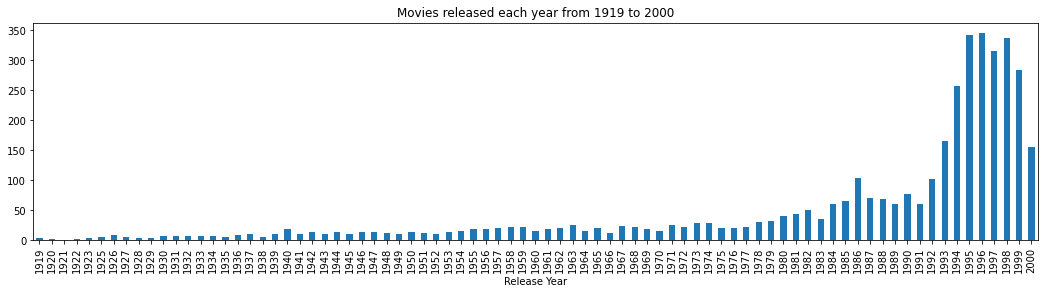

In [247]:
ax = plt.figure(figsize=(18,4))
df_movies.groupby('Release Year').count()['Movie ID'].plot(kind='bar')
plt.title('Movies released each year from 1919 to 2000')
plt.show()

In [248]:
df_movies_ratings = df_ratings.merge(df_movies,left_on='MovieID',right_on='Movie ID')

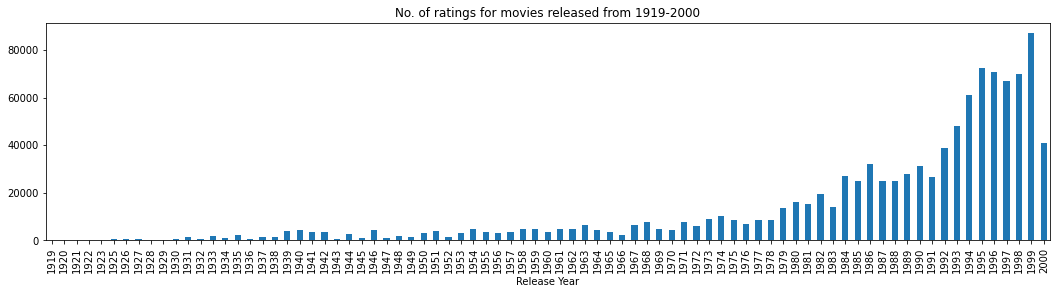

In [249]:
ax = plt.figure(figsize=(18,4))
df_movies_ratings.groupby('Release Year').count()['Rating'].replace(np.inf, -1).plot(kind='bar')
plt.title('No. of ratings for movies released from 1919-2000')
plt.show()

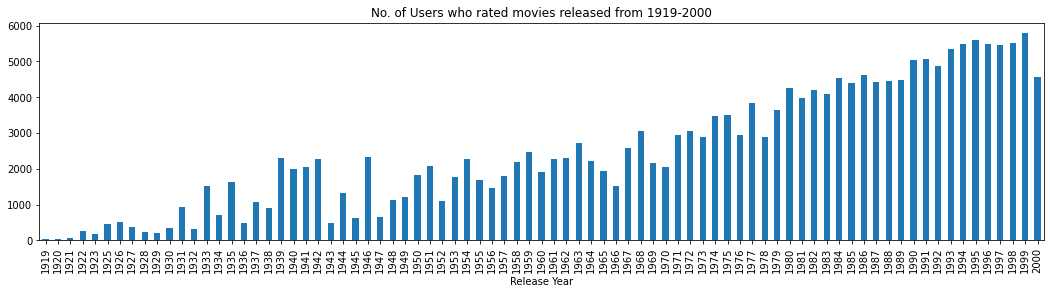

In [250]:
ax = plt.figure(figsize=(18,4))
df_movies_ratings.groupby('Release Year').nunique()['UserID'].replace(np.inf, -1).plot(kind='bar')
plt.title('No. of Users who rated movies released from 1919-2000')
plt.show()

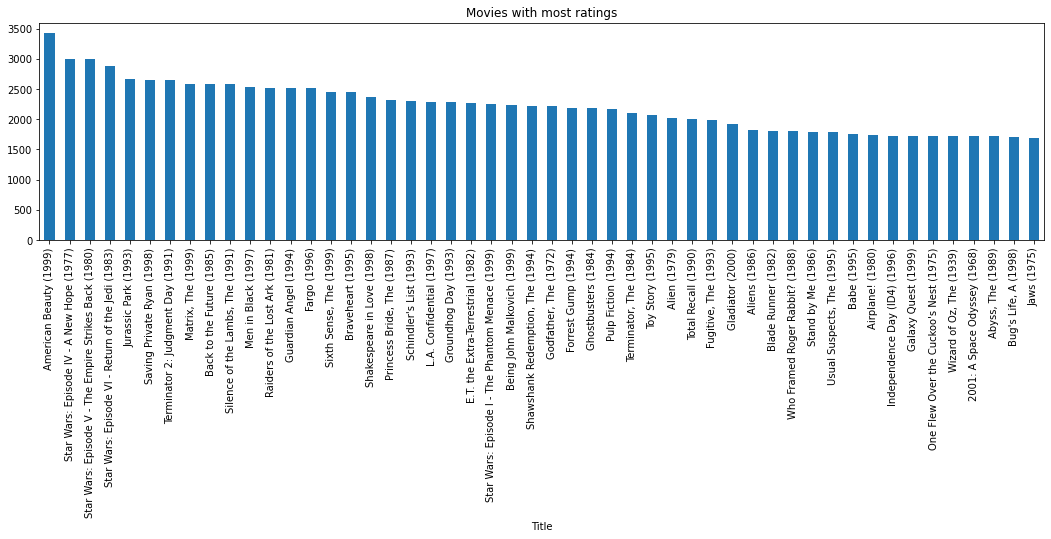

In [251]:
ax = plt.figure(figsize=(18,4))
df_movies_ratings.groupby('Title').count().sort_values('Rating',ascending=False)['Rating'].head(50).plot(kind='bar')
plt.title('Movies with most ratings')
plt.show()

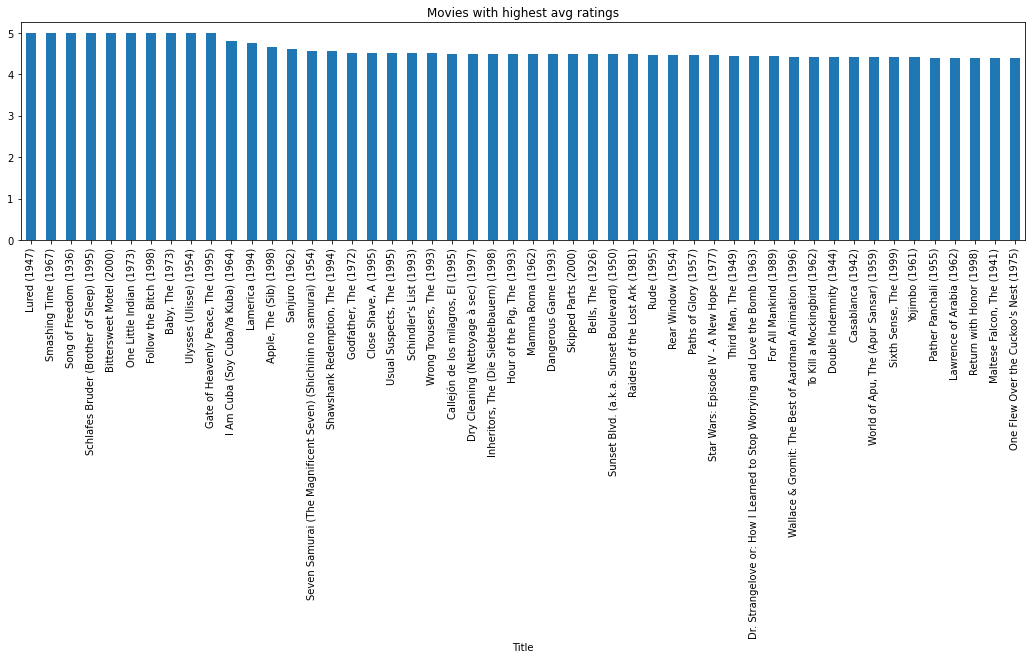

In [252]:
ax = plt.figure(figsize=(18,4))
df_movies_ratings.groupby('Title').mean().sort_values('Rating',ascending=False)['Rating'].head(50).plot(kind='bar')
plt.title('Movies with highest avg ratings')
plt.show()

In [253]:
df_movies_ratings.groupby('Title')

**Insights**
1. Recently released movies have more reviews.
2. Star wars series has lot of reviews.
3. Sci-fi/ Fantasy genre has most number of reviews

**EDA on Users**

In [254]:
df_users_ratings = df_ratings.merge(df_users,on='UserID')

In [255]:
df_users_ratings

,UserID,MovieID,Rating,Timestamp,Gender,Age,Occupation,Zip-code
0,0,0,5.0,978300760,F,Under 18,K-12 student,48067
1,0,1,3.0,978302109,F,Under 18,K-12 student,48067
2,0,2,3.0,978301968,F,Under 18,K-12 student,48067
3,0,3,4.0,978300275,F,Under 18,K-12 student,48067
4,0,4,5.0,978824291,F,Under 18,K-12 student,48067
...,...,...,...,...,...,...,...,...
1000204,6039,772,1.0,956716541,M,25-34,doctor/health care,11106
1000205,6039,1106,5.0,956704887,M,25-34,doctor/health care,11106
1000206,6039,365,5.0,956704746,M,25-34,doctor/health care,11106
1000207,6039,152,4.0,956715648,M,25-34,doctor/health care,11106


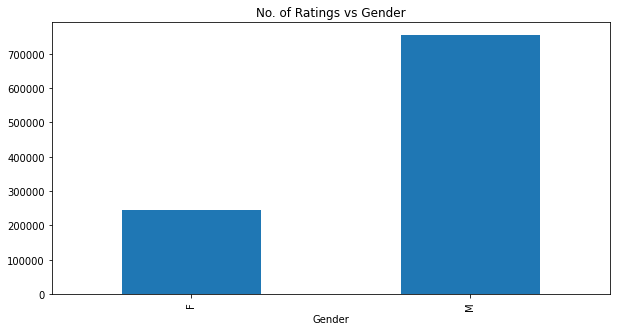

In [256]:
df_users_ratings.groupby('Gender').count()['MovieID'].plot(kind='bar')
plt.title("No. of Ratings vs Gender")
plt.show()

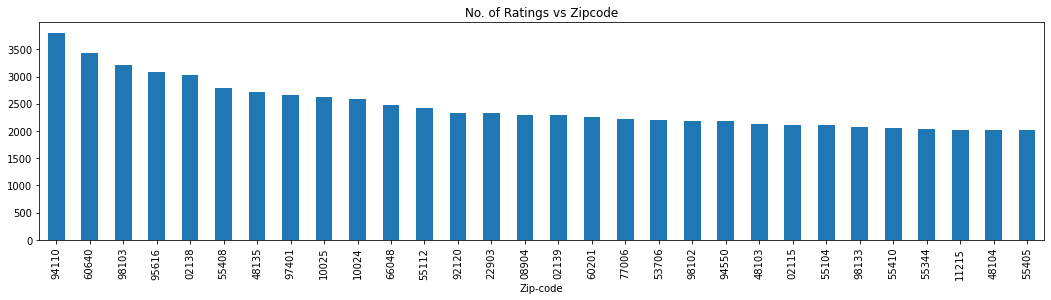

In [257]:
ax = plt.figure(figsize=(18,4))
df_users_ratings.groupby('Zip-code').count().sort_values('Rating',ascending=False)['Rating'].head(30).plot(kind='bar')
plt.title("No. of Ratings vs Zipcode")
plt.show()

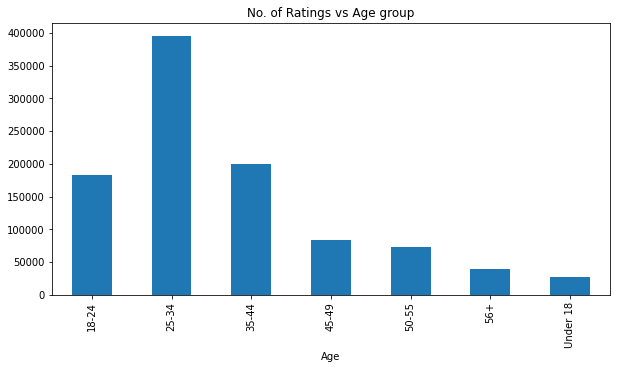

In [258]:
df_users_ratings.groupby('Age').count()['MovieID'].plot(kind='bar')
plt.title("No. of Ratings vs Age group")
plt.show()

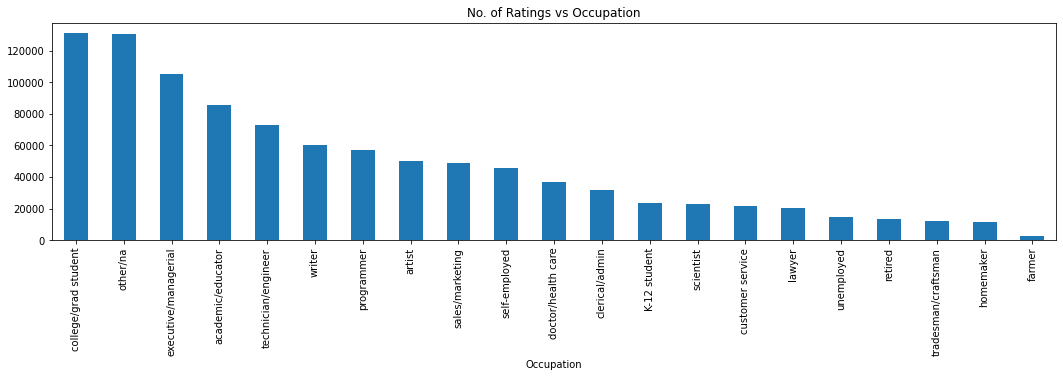

In [259]:
ax = plt.figure(figsize=(18,4))
df_users_ratings.groupby('Occupation').count().sort_values('Rating',ascending=False)['Rating'].head(30).plot(kind='bar')
plt.title("No. of Ratings vs Occupation")
plt.show()

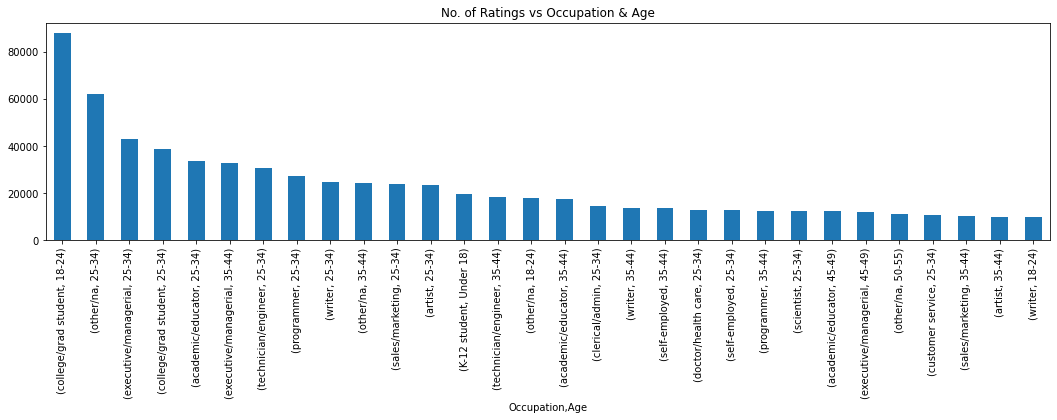

In [260]:
ax = plt.figure(figsize=(18,4))
df_users_ratings.groupby(['Occupation','Age']).count().sort_values('Rating',ascending=False)['Rating'].head(30).plot(kind='bar')
plt.title("No. of Ratings vs Occupation & Age")
plt.show()

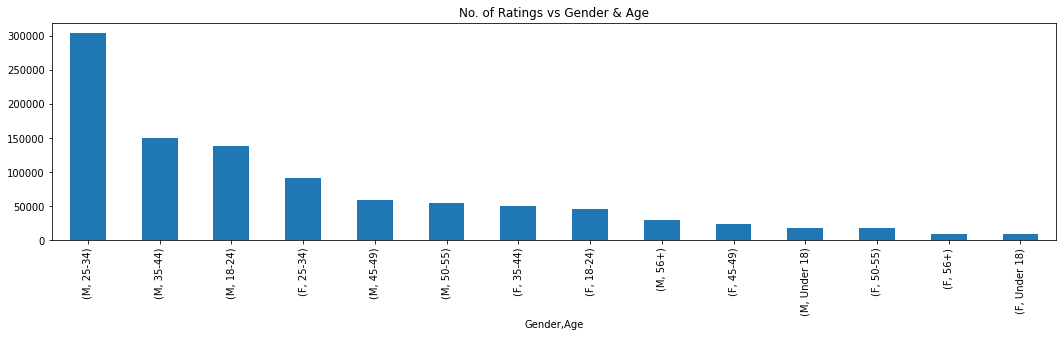

In [261]:
ax = plt.figure(figsize=(18,4))
df_users_ratings.groupby(['Gender','Age']).count().sort_values('Rating',ascending=False)['Rating'].head(30).plot(kind='bar')
plt.title("No. of Ratings vs Gender & Age")
plt.show()

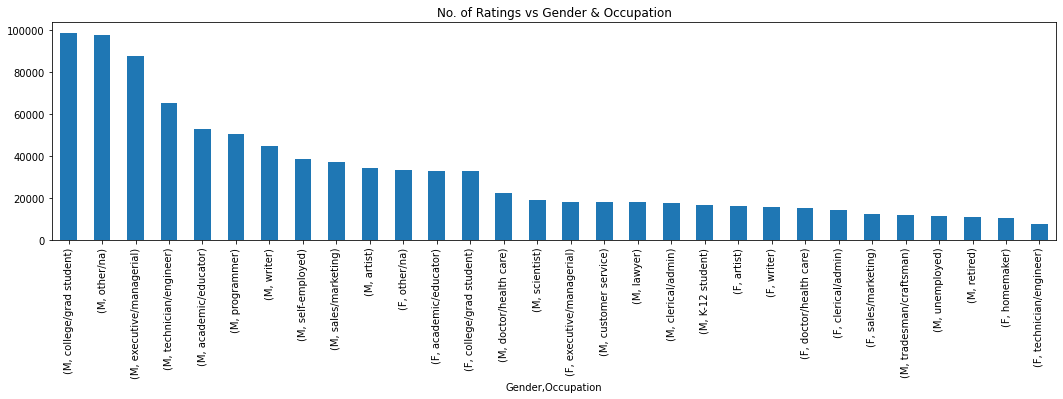

In [262]:
ax = plt.figure(figsize=(18,4))
df_users_ratings.groupby(['Gender','Occupation']).count().sort_values('Rating',ascending=False)['Rating'].head(30).plot(kind='bar')
plt.title("No. of Ratings vs Gender & Occupation")
plt.show()

**Insights**
1. Reviews given by males is more than 3 times as that of females, this means reviews might be biased towards one kind of users.
2. Users from 94110 zipcode has most number of review.
3. Most reviews are given by users between 25-34.
4. College students have highest number of reviews.
5. Females with age between 25-34 hv given most reviews amt females.


In [323]:
df_users_movies_ratings = df_users_ratings.merge(df_movies.reset_index(drop=True),left_on='MovieID',right_on=['Movie ID'])

In [340]:
df_tmp = df_movies_ratings.groupby('Title').count()['Rating'].reset_index()

In [344]:
movies = df_tmp[df_tmp['Rating'] >250]['Title'].values

In [345]:
df_tmp = df_users_movies_ratings[df_users_movies_ratings['Title'].isin(movies)].groupby(['Title','Gender']).mean().sort_values('Rating',ascending=False)['Rating'].reset_index()

**Top rated movies Gender wise**

In [349]:
c

,Title,Gender,Rating
0,"Close Shave, A (1995)",F,4.644444
1,"Wrong Trousers, The (1993)",F,4.588235
4,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),F,4.572650
5,Wallace & Gromit: The Best of Aardman Animatio...,F,4.563107
6,Schindler's List (1993),F,4.562602


In [350]:
df_tmp[df_tmp['Gender'] == 'M'].head()

,Title,Gender,Rating
2,"Godfather, The (1972)",M,4.583333
3,Seven Samurai (The Magnificent Seven) (Shichin...,M,4.576628
7,"Shawshank Redemption, The (1994)",M,4.560625
11,Raiders of the Lost Ark (1981),M,4.520597
12,"Usual Suspects, The (1995)",M,4.518248


In [351]:
df_tmp = df_users_movies_ratings[df_users_movies_ratings['Title'].isin(movies)].groupby(['Title','Occupation']).mean().sort_values('Rating',ascending=False)['Rating'].reset_index()

**Top rated movies Occupation wise**

In [358]:
for i in occupation_mapping.values():
    print('Top Movies liked by: ',i)
    display(df_tmp[df_tmp['Occupation']==i].head(3))
    print()

Top Movies liked by:  other/na


,Title,Occupation,Rating
263,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),other/na,4.671642
416,M (1931),other/na,4.600000
520,"Third Man, The (1949)",other/na,4.571429



Top Movies liked by:  academic/educator


,Title,Occupation,Rating
336,Seven Samurai (The Magnificent Seven) (Shichin...,academic/educator,4.649351
402,"Maltese Falcon, The (1941)",academic/educator,4.608696
532,"Usual Suspects, The (1995)",academic/educator,4.561644



Top Movies liked by:  artist


,Title,Occupation,Rating
228,"Manchurian Candidate, The (1962)",artist,4.727273
231,"Close Shave, A (1995)",artist,4.722222
363,When We Were Kings (1996),artist,4.625000



Top Movies liked by:  clerical/admin


,Title,Occupation,Rating
190,Modern Times (1936),clerical/admin,4.800
203,Raise the Red Lantern (1991),clerical/admin,4.800
229,Rear Window (1954),clerical/admin,4.725



Top Movies liked by:  college/grad student


,Title,Occupation,Rating
257,"Shawshank Redemption, The (1994)",college/grad student,4.683582
262,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),college/grad student,4.675676
337,"Usual Suspects, The (1995)",college/grad student,4.649123



Top Movies liked by:  customer service


,Title,Occupation,Rating
42,Shallow Grave (1994),customer service,5.0
106,My Life as a Dog (Mitt liv som hund) (1985),customer service,5.0
170,"Mrs. Brown (Her Majesty, Mrs. Brown) (1997)",customer service,5.0



Top Movies liked by:  doctor/health care


,Title,Occupation,Rating
240,"Shawshank Redemption, The (1994)",doctor/health care,4.711340
241,Schindler's List (1993),doctor/health care,4.705263
252,Salut cousin! (1996),doctor/health care,4.692308



Top Movies liked by:  executive/managerial


,Title,Occupation,Rating
260,"Wrong Trousers, The (1993)",executive/managerial,4.677966
403,"Godfather, The (1972)",executive/managerial,4.607914
482,"Shawshank Redemption, The (1994)",executive/managerial,4.576419



Top Movies liked by:  farmer


,Title,Occupation,Rating
1,It Happened One Night (1934),farmer,5.0
4,Cinema Paradiso (1988),farmer,5.0
5,Big Night (1996),farmer,5.0



Top Movies liked by:  homemaker


,Title,Occupation,Rating
13,Pitch Black (2000),homemaker,5.0
16,"Third Man, The (1949)",homemaker,5.0
59,54 (1998),homemaker,5.0



Top Movies liked by:  K-12 student


,Title,Occupation,Rating
0,"'burbs, The (1989)",K-12 student,5.0
3,"Apostle, The (1997)",K-12 student,5.0
6,"Big Sleep, The (1946)",K-12 student,5.0



Top Movies liked by:  lawyer


,Title,Occupation,Rating
173,Casablanca (1942),lawyer,4.866667
175,When We Were Kings (1996),lawyer,4.833333
186,Farmer & Chase (1995),lawyer,4.800000



Top Movies liked by:  programmer


,Title,Occupation,Rating
204,Bringing Up Baby (1938),programmer,4.785714
206,Seven Samurai (The Magnificent Seven) (Shichin...,programmer,4.763158
288,Salut cousin! (1996),programmer,4.666667



Top Movies liked by:  retired


,Title,Occupation,Rating
72,"Wrong Trousers, The (1993)",retired,5.0
76,Six Degrees of Separation (1993),retired,5.0
80,Singles (1992),retired,5.0



Top Movies liked by:  sales/marketing


,Title,Occupation,Rating
195,All About Eve (1950),sales/marketing,4.800000
225,"Close Shave, A (1995)",sales/marketing,4.739130
233,City Lights (1931),sales/marketing,4.714286



Top Movies liked by:  scientist


,Title,Occupation,Rating
2,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),scientist,5.000000
21,Guess Who's Coming to Dinner (1967),scientist,5.000000
177,Squeeze (1996),scientist,4.833333



Top Movies liked by:  self-employed


,Title,Occupation,Rating
182,Double Indemnity (1944),self-employed,4.807692
205,"Bicycle Thief, The (Ladri di biciclette) (1948)",self-employed,4.777778
214,City Lights (1931),self-employed,4.750000



Top Movies liked by:  technician/engineer


,Title,Occupation,Rating
245,Wallace & Gromit: The Best of Aardman Animatio...,technician/engineer,4.70
246,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),technician/engineer,4.70
350,"Treasure of the Sierra Madre, The (1948)",technician/engineer,4.64



Top Movies liked by:  tradesman/craftsman


,Title,Occupation,Rating
10,"Apartment, The (1960)",tradesman/craftsman,5.0
17,It Could Happen to You (1994),tradesman/craftsman,5.0
25,Welcome to the Dollhouse (1995),tradesman/craftsman,5.0



Top Movies liked by:  unemployed


,Title,Occupation,Rating
35,Being There (1979),unemployed,5.0
44,City Lights (1931),unemployed,5.0
90,Inherit the Wind (1960),unemployed,5.0



Top Movies liked by:  writer


,Title,Occupation,Rating
360,To Kill a Mockingbird (1962),writer,4.629630
361,"Godfather, The (1972)",writer,4.629310
401,Casablanca (1942),writer,4.608696


In [359]:
df_tmp = df_users_movies_ratings[df_users_movies_ratings['Title'].isin(movies)].groupby(['Title','Age']).mean().sort_values('Rating',ascending=False)['Rating'].reset_index()

**Top rated movies Age group wise**

In [360]:
for i in age_mapping.values():
    print('Top Movies liked by age group: ',i)
    display(df_tmp[df_tmp['Age']==i].head(3))
    print()

Top Movies liked by age group:  Under 18


,Title,Age,Rating
0,Somewhere in Time (1980),Under 18,5.0
3,Night Shift (1982),Under 18,5.0
4,Breaking the Waves (1996),Under 18,5.0



Top Movies liked by age group:  18-24


,Title,Age,Rating
20,"Usual Suspects, The (1995)",18-24,4.680798
22,"Shawshank Redemption, The (1994)",18-24,4.674569
50,Seven Samurai (The Magnificent Seven) (Shichin...,18-24,4.604938



Top Movies liked by age group:  25-34


,Title,Age,Rating
59,"Shawshank Redemption, The (1994)",25-34,4.587699
64,Raiders of the Lost Ark (1981),25-34,4.578521
65,"Godfather, The (1972)",25-34,4.574051



Top Movies liked by age group:  35-44


,Title,Age,Rating
47,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),35-44,4.611570
60,To Kill a Mockingbird (1962),35-44,4.585859
62,City Lights (1931),35-44,4.581818



Top Movies liked by age group:  45-49


,Title,Age,Rating
34,"Wrong Trousers, The (1993)",45-49,4.647059
37,"Bicycle Thief, The (Ladri di biciclette) (1948)",45-49,4.636364
49,"Close Shave, A (1995)",45-49,4.607143



Top Movies liked by age group:  50-55


,Title,Age,Rating
18,Real Genius (1985),50-55,4.714286
32,"Wrong Trousers, The (1993)",50-55,4.660000
33,Seven Samurai (The Magnificent Seven) (Shichin...,50-55,4.657143



Top Movies liked by age group:  56+


,Title,Age,Rating
1,Creature Comforts (1990),56+,5.000000
2,Better Off Dead... (1985),56+,5.000000
16,"Wrong Trousers, The (1993)",56+,4.722222


<div style="font-family:verdana; word-spacing:0.5px;">
<p style="background-color:#0cd734;color:white;text-align:center;font-size:175%;padding: 2px;"> Creating Pivots or utility matrix</p>
</div>    

**Creating pivot**

In [263]:
df_ratings['UserID'] = df_ratings['UserID'].astype('int')
df_ratings['MovieID'] = df_ratings['MovieID'].astype('int')

In [264]:
df_pivot = pd.pivot_table(df_ratings,columns=['MovieID'],index=['UserID'],values=['Rating']).droplevel(0, axis=1) 

In [265]:
df_pivot

MovieID,0,1,2,3,4,5,6,7,8,9,...,3696,3697,3698,3699,3700,3701,3702,3703,3704,3705
UserID,,,,,,,,,,,,,,,,,,,,,
0,5.0,3.0,3.0,4.0,5.0,3.0,5.0,5.0,4.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,3.0,5.0,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035,5.0,NaN,3.0,4.0,4.0,5.0,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6036,4.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Adding columns for movies with no ratings**

In [266]:
for col in list(set(df_movies['Movie ID']) - set(df_pivot.columns)):
    df_pivot[col] = np.nan

**Imputaion of NaNs with column mean**

In [267]:
fill_mean = lambda col : col.fillna(col.mean())

df_impute_col = df_pivot.apply(fill_mean, axis = 0).dropna(axis=1)

In [268]:
df_impute_col

MovieID,0,1,2,3,4,5,6,7,8,9,...,3696,3697,3698,3699,3700,3701,3702,3703,3704,3705
UserID,,,,,,,,,,,,,,,,,,,,,
0,5.000000,3.000000,3.000000,4.000000,5.000000,3.00000,5.000000,5.000000,4.000000,4.000000,...,1.0,5.0,3.0,3.0,4.0,4.0,3.0,1.0,5.0,4.0
1,5.000000,3.464762,4.154088,3.863878,3.854375,4.30371,4.110795,4.238905,3.845347,4.247963,...,1.0,5.0,3.0,3.0,4.0,4.0,3.0,1.0,5.0,4.0
2,4.390725,3.464762,4.154088,3.863878,5.000000,5.00000,4.110795,4.238905,3.845347,4.247963,...,1.0,5.0,3.0,3.0,4.0,4.0,3.0,1.0,5.0,4.0
3,4.390725,3.464762,4.154088,3.863878,3.854375,4.30371,4.110795,4.238905,3.845347,4.247963,...,1.0,5.0,3.0,3.0,4.0,4.0,3.0,1.0,5.0,4.0
4,4.390725,3.464762,4.154088,3.000000,5.000000,4.30371,4.110795,4.238905,3.845347,4.000000,...,1.0,5.0,3.0,3.0,4.0,4.0,3.0,1.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035,5.000000,3.464762,3.000000,4.000000,4.000000,5.00000,4.110795,4.238905,5.000000,4.247963,...,1.0,5.0,3.0,3.0,4.0,4.0,3.0,1.0,5.0,4.0
6036,4.000000,3.464762,4.154088,3.863878,3.854375,4.30371,4.110795,4.000000,3.845347,4.000000,...,1.0,5.0,3.0,3.0,4.0,4.0,3.0,1.0,5.0,4.0
6037,4.390725,3.464762,4.154088,3.863878,3.854375,4.30371,4.110795,4.238905,3.845347,4.247963,...,1.0,5.0,3.0,3.0,4.0,4.0,3.0,1.0,5.0,4.0


**Imputaion of NaNs with row mean**

In [269]:
fill_mean = lambda col : col.fillna(col.mean())


df_impute_row = df_pivot.apply(fill_mean, axis = 1)

In [270]:
df_impute_row

MovieID,0,1,2,3,4,5,6,7,8,9,...,3700,3701,3702,3703,3704,3705,3856,3907,3829,3750
UserID,,,,,,,,,,,,,,,,,,,,,
0,5.000000,3.000000,3.000000,4.000000,5.000000,3.000000,5.000000,5.000000,4.000000,4.000000,...,4.188679,4.188679,4.188679,4.188679,4.188679,4.188679,4.188679,4.188679,4.188679,4.188679
1,5.000000,3.713178,3.713178,3.713178,3.713178,3.713178,3.713178,3.713178,3.713178,3.713178,...,3.713178,3.713178,3.713178,3.713178,3.713178,3.713178,3.713178,3.713178,3.713178,3.713178
2,3.901961,3.901961,3.901961,3.901961,5.000000,5.000000,3.901961,3.901961,3.901961,3.901961,...,3.901961,3.901961,3.901961,3.901961,3.901961,3.901961,3.901961,3.901961,3.901961,3.901961
3,4.190476,4.190476,4.190476,4.190476,4.190476,4.190476,4.190476,4.190476,4.190476,4.190476,...,4.190476,4.190476,4.190476,4.190476,4.190476,4.190476,4.190476,4.190476,4.190476,4.190476
4,3.146465,3.146465,3.146465,3.000000,5.000000,3.146465,3.146465,3.146465,3.146465,4.000000,...,3.146465,3.146465,3.146465,3.146465,3.146465,3.146465,3.146465,3.146465,3.146465,3.146465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035,5.000000,3.302928,3.000000,4.000000,4.000000,5.000000,3.302928,3.302928,5.000000,3.302928,...,3.302928,3.302928,3.302928,3.302928,3.302928,3.302928,3.302928,3.302928,3.302928,3.302928
6036,4.000000,3.717822,3.717822,3.717822,3.717822,3.717822,3.717822,4.000000,3.717822,4.000000,...,3.717822,3.717822,3.717822,3.717822,3.717822,3.717822,3.717822,3.717822,3.717822,3.717822
6037,3.800000,3.800000,3.800000,3.800000,3.800000,3.800000,3.800000,3.800000,3.800000,3.800000,...,3.800000,3.800000,3.800000,3.800000,3.800000,3.800000,3.800000,3.800000,3.800000,3.800000


In [271]:
df_ratings['MovieID'].nunique(),df_ratings['UserID'].nunique()

(3706, 6040)

<div style="font-family:verdana; word-spacing:0.5px;">
<p style="background-color:#0cd734;color:white;text-align:center;font-size:175%;padding: 2px;">Recommender Sys</p>
</div>    

**Recommendations based on pearson correlation**

In [272]:
from scipy.stats.stats import pearsonr  

In [273]:
def get_movie_recommend_pearson(name,ratings):
    movie_id = int(df_movies[df_movies['Title'] == name]['Movie ID'].iloc[0])
    kj = ratings[movie_id].values
    moviesa = [(i,pearsonr(kj,ratings[i].values)) for i in ratings.columns]
    moviesa.sort(key=lambda x:x[1],reverse=True )
    df_movies.index = df_movies['Movie ID']
    return df_movies.loc[[i[0] for i in moviesa[1:6]]].reset_index(drop=True)

In [274]:
name = "Snow White and the Seven Dwarfs (1937)"
##based on rowise imputed utility matrix
get_movie_recommend_pearson(name,df_impute_row) 

,Movie ID,Title,Genres,Release Year
0,37,Cinderella (1950),Animation|Children's|Musical,1950
1,632,Sleeping Beauty (1959),Animation|Children's|Musical,1959
2,3617,Dangerous Ground (1997),Drama,1997
3,3050,Rosie (1998),Drama,1998
4,2986,Kim (1950),Children's|Drama,1950


In [275]:
##based on columnwise imputed utility matrix
get_movie_recommend_pearson(name,df_impute_col)

/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


,Movie ID,Title,Genres,Release Year
0,37,Cinderella (1950),Animation|Children's|Musical,1950
1,632,Sleeping Beauty (1959),Animation|Children's|Musical,1959
2,17,Bambi (1942),Animation|Children's,1942
3,46,Dumbo (1941),Animation|Children's|Musical,1941
4,588,Pinocchio (1940),Animation|Children's,1940


In [276]:
name = "Mortal Kombat (1995)"
##based on rowise imputed utility matrix
get_movie_recommend_pearson(name,df_impute_row)

,Movie ID,Title,Genres,Release Year
0,2684,Cavalcade (1933),Drama,1933
1,2684,Taxman (1999),Comedy|Drama,1999
2,3692,Tough and Deadly (1995),Action|Drama|Thriller,1995
3,3147,Talking About Sex (1994),Comedy|Drama,1994
4,3479,Beauty (1998),Drama,1998
5,3424,"Strike! (a.k.a. All I Wanna Do, The Hairy Bird...",Comedy,1998


In [277]:
##based on columnwise imputed utility matrix
get_movie_recommend_pearson(name,df_impute_col)

/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


,Movie ID,Title,Genres,Release Year
0,1250,Universal Soldier (1992),Action|Sci-Fi,1992
1,1184,Judge Dredd (1995),Action|Adventure|Sci-Fi,1995
2,569,Teenage Mutant Ninja Turtles II: The Secret of...,Action|Children's|Fantasy,1991
3,2782,No Escape (1994),Action|Sci-Fi,1994
4,1057,Highlander III: The Sorcerer (1994),Action|Sci-Fi,1994


**Creating Sparse matrix**

In [278]:
from scipy.sparse import csr_matrix


In [279]:
sparse_matrix = csr_matrix(df_pivot, dtype=np.int8)
sparse_matrix

<6040x3710 sparse matrix of type '<class 'numpy.int8'>'
	with 22408400 stored elements in Compressed Sparse Row format>

In [280]:
sparse_matrix.toarray()

array([[5, 3, 3, ..., 0, 0, 0],
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 3, 4, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0]], dtype=int8)

**Recommendations based on Cosine similarity**

In [281]:
from scipy import spatial
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances

In [282]:
user_similarity = csr_matrix(pairwise_distances(df_impute_row,metric='cosine'))
item_similarity = csr_matrix(pairwise_distances(df_impute_row.T,metric='cosine'))

**User-User similarity Matrix**

In [283]:
user_similarity.toarray()

array([[0.00000000e+00, 1.40608459e-03, 6.32403250e-04, ...,
        4.01591411e-04, 7.60859139e-04, 5.11957203e-03],
       [1.40608459e-03, 0.00000000e+00, 1.64660116e-03, ...,
        1.48241707e-03, 1.77944516e-03, 6.22428917e-03],
       [6.32403250e-04, 1.64660116e-03, 2.24265051e-14, ...,
        6.17204378e-04, 9.63371133e-04, 5.49419171e-03],
       ...,
       [4.01591411e-04, 1.48241707e-03, 6.17204378e-04, ...,
        4.04121181e-14, 7.68898697e-04, 5.24183749e-03],
       [7.60859139e-04, 1.77944516e-03, 9.63371133e-04, ...,
        7.68898697e-04, 6.21724894e-14, 5.32520930e-03],
       [5.11957203e-03, 6.22428917e-03, 5.49419171e-03, ...,
        5.24183749e-03, 5.32520930e-03, 6.11732887e-14]])

**Item-Item similarity Matrix**

In [284]:
item_similarity.toarray()

array([[0.00000000e+00, 1.15973241e-02, 1.11688054e-02, ...,
        8.64979521e-03, 8.64979521e-03, 8.64979521e-03],
       [1.15973241e-02, 1.11022302e-16, 6.25884252e-03, ...,
        3.04094944e-03, 3.04094944e-03, 3.04094944e-03],
       [1.11688054e-02, 6.25884252e-03, 0.00000000e+00, ...,
        3.05984676e-03, 3.05984676e-03, 3.05984676e-03],
       ...,
       [8.64979521e-03, 3.04094944e-03, 3.05984676e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.64979521e-03, 3.04094944e-03, 3.05984676e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.64979521e-03, 3.04094944e-03, 3.05984676e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [285]:
df_movies.index = df_movies['Movie ID'].astype(int)

In [286]:
df_impute_row

MovieID,0,1,2,3,4,5,6,7,8,9,...,3700,3701,3702,3703,3704,3705,3856,3907,3829,3750
UserID,,,,,,,,,,,,,,,,,,,,,
0,5.000000,3.000000,3.000000,4.000000,5.000000,3.000000,5.000000,5.000000,4.000000,4.000000,...,4.188679,4.188679,4.188679,4.188679,4.188679,4.188679,4.188679,4.188679,4.188679,4.188679
1,5.000000,3.713178,3.713178,3.713178,3.713178,3.713178,3.713178,3.713178,3.713178,3.713178,...,3.713178,3.713178,3.713178,3.713178,3.713178,3.713178,3.713178,3.713178,3.713178,3.713178
2,3.901961,3.901961,3.901961,3.901961,5.000000,5.000000,3.901961,3.901961,3.901961,3.901961,...,3.901961,3.901961,3.901961,3.901961,3.901961,3.901961,3.901961,3.901961,3.901961,3.901961
3,4.190476,4.190476,4.190476,4.190476,4.190476,4.190476,4.190476,4.190476,4.190476,4.190476,...,4.190476,4.190476,4.190476,4.190476,4.190476,4.190476,4.190476,4.190476,4.190476,4.190476
4,3.146465,3.146465,3.146465,3.000000,5.000000,3.146465,3.146465,3.146465,3.146465,4.000000,...,3.146465,3.146465,3.146465,3.146465,3.146465,3.146465,3.146465,3.146465,3.146465,3.146465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035,5.000000,3.302928,3.000000,4.000000,4.000000,5.000000,3.302928,3.302928,5.000000,3.302928,...,3.302928,3.302928,3.302928,3.302928,3.302928,3.302928,3.302928,3.302928,3.302928,3.302928
6036,4.000000,3.717822,3.717822,3.717822,3.717822,3.717822,3.717822,4.000000,3.717822,4.000000,...,3.717822,3.717822,3.717822,3.717822,3.717822,3.717822,3.717822,3.717822,3.717822,3.717822
6037,3.800000,3.800000,3.800000,3.800000,3.800000,3.800000,3.800000,3.800000,3.800000,3.800000,...,3.800000,3.800000,3.800000,3.800000,3.800000,3.800000,3.800000,3.800000,3.800000,3.800000


In [287]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(metric='cosine')
knn.fit(df_impute_row.T.values)
distances, indices = knn.kneighbors(df_impute_row.T, n_neighbors=6)

In [288]:
def get_recommendations_cosine(name):
    movie_id = int(df_movies[df_movies['Title'] == name]['Movie ID'].iloc[0])
    
    movies = indices[movie_id,:]
    display(df_movies.loc[movies[1:]])
    

In [289]:
name = 'Alice in Wonderland (1951)'
get_recommendations_cosine(name)

,Movie ID,Title,Genres,Release Year
Movie ID,,,,
2248,2248,Diebinnen (1995),Drama,1995
3608,3608,Leather Jacket Love Story (1997),Drama|Romance,1997
3679,3679,Dangerous Game (1993),Drama,1993
3462,3462,Broadway Damage (1997),Comedy,1997
3651,3651,Impact (1949),Crime|Drama,1949


In [290]:
name = 'Misérables, Les (1995)'
get_recommendations_cosine(name)

,Movie ID,Title,Genres,Release Year
Movie ID,,,,
3493,3493,Black Tar Heroin: The Dark End of the Street (...,Documentary,1999
3352,3352,In the Line of Duty 2 (1987),Action,1987
3489,3489,"Bells, The (1926)",Crime|Drama,1926
3265,3265,Harlem (1993),Drama,1993
3453,3453,Savior (1998),Drama,1998


**Recommendaations based on Matrix Factorization**

In [291]:
split = np.random.rand(len(df_ratings)) < 0.8
train = df_ratings[split]
valid = df_ratings[~split]
print(train.shape , valid.shape)

(799793, 4) (200416, 4)


In [292]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense , merge
#from keras.optimizers import SGD,Adagrad,Adadelta,RMSprop
#from keras.utils import to_categorical
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import ReduceLROnPlateau


from keras.layers.merge import dot
from keras.models import Model


# specifically for deeplearning.
from keras.layers import Dropout, Flatten,Activation,Input,Embedding
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
import tensorflow as tf
import random as rn
from IPython.display import SVG

In [293]:
from keras.optimizers import gradient_descent_v2, adam_v2 
from keras.metrics import MeanSquaredError, RootMeanSquaredError, MeanAbsolutePercentageError

In [294]:
n_movies=len(df_ratings['MovieID'].unique())
n_users=len(df_ratings['UserID'].unique())
n_latent_factors=20  # hyperparamter to deal with.

In [295]:
user_input=Input(shape=(1,),name='user_input',dtype='int64')
user_embedding=Embedding(n_users,n_latent_factors,name='user_embedding')(user_input)
user_vec =Flatten(name='FlattenUsers')(user_embedding)

In [296]:
movie_input=Input(shape=(1,),name='movie_input',dtype='int64')
movie_embedding=Embedding(n_movies,n_latent_factors,name='movie_embedding')(movie_input)
movie_vec=Flatten(name='FlattenMovies')(movie_embedding)

In [297]:
sim=dot([user_vec,movie_vec],name='Simalarity-Dot-Product',axes=1)
model =keras.models.Model([user_input, movie_input],sim)

**Model Summary**

In [298]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 20)        120800      user_input[0][0]                 
__________________________________________________________________________________________________
movie_embedding (Embedding)     (None, 1, 20)        74120       movie_input[0][0]                
____________________________________________________________________________________________

**Metric: MSE**

In [299]:
model.compile(optimizer=adam_v2.Adam(lr=1e-4),loss='mse',metrics=[MeanSquaredError(), RootMeanSquaredError(), MeanAbsolutePercentageError(), ])


train.shape
batch_size=128
epochs=30

History = model.fit([train['UserID'],train['MovieID']],train.Rating, batch_size=batch_size,
                              epochs =epochs, validation_data = ([valid['UserID'],valid['MovieID']],valid.Rating),
                              verbose = 1)


Epoch 1/30


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


6249/6249 [==============================] - 26s 4ms/step - loss: 14.0469 - mean_squared_error: 14.0469 - root_mean_squared_error: 3.7479 - mean_absolute_percentage_error: 99.8807 - val_loss: 13.8842 - val_mean_squared_error: 13.8842 - val_root_mean_squared_error: 3.7262 - val_mean_absolute_percentage_error: 99.1509
Epoch 2/30
6249/6249 [==============================] - 25s 4ms/step - loss: 12.4265 - mean_squared_error: 12.4265 - root_mean_squared_error: 3.5251 - mean_absolute_percentage_error: 92.4245 - val_loss: 10.2752 - val_mean_squared_error: 10.2752 - val_root_mean_squared_error: 3.2055 - val_mean_absolute_percentage_error: 81.7633
Epoch 3/30
6249/6249 [==============================] - 25s 4ms/step - loss: 7.5991 - mean_squared_error: 7.5991 - root_mean_squared_error: 2.7566 - mean_absolute_percentage_error: 67.0725 - val_loss: 5.1979 - val_mean_squared_error: 5.1979 - val_root_mean_squared_error: 2.2799 - val_mean_absolute_percentage_error: 53.3727
Epoch 4/30
6249/6249 [======

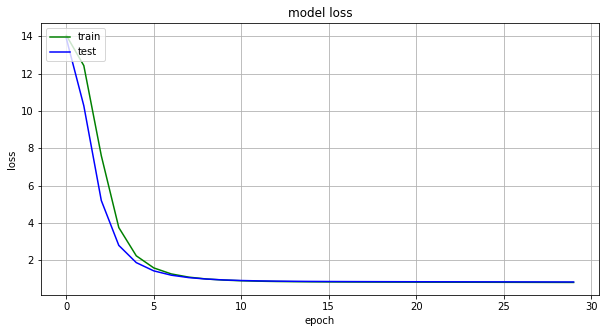

In [308]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
import matplotlib.pyplot as plt
plt.plot(History.history['loss'] , 'g')
plt.plot(History.history['val_loss'] , 'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

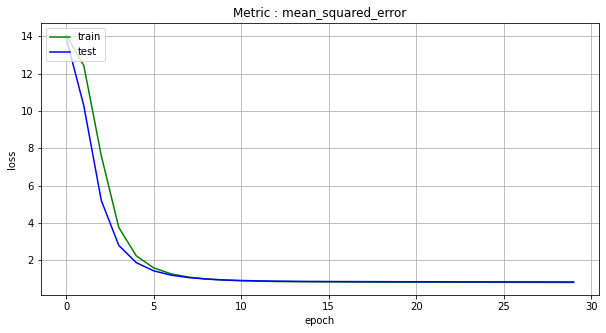

In [309]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
import matplotlib.pyplot as plt
plt.plot(History.history['mean_squared_error'] , 'g')
plt.plot(History.history['val_mean_squared_error'] , 'b')
plt.title('Metric : mean_squared_error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

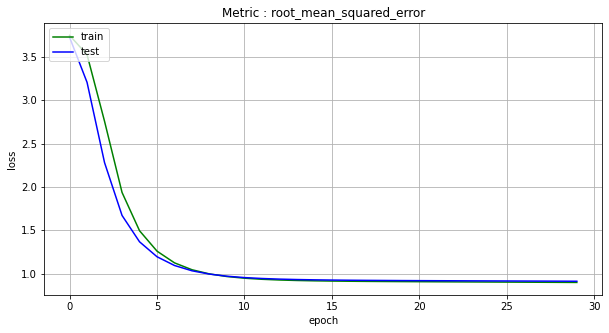

In [310]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
import matplotlib.pyplot as plt
plt.plot(History.history['root_mean_squared_error'] , 'g')
plt.plot(History.history['val_root_mean_squared_error'] , 'b')
plt.title('Metric : root_mean_squared_error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

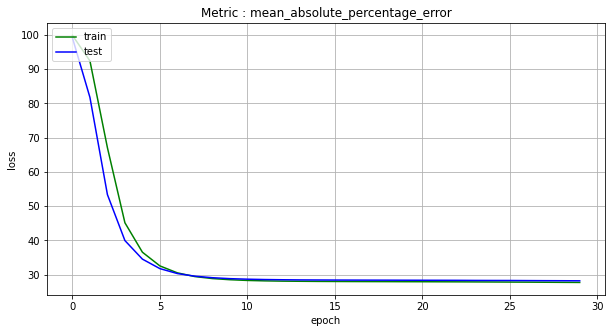

In [311]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
import matplotlib.pyplot as plt
plt.plot(History.history['mean_absolute_percentage_error'] , 'g')
plt.plot(History.history['val_mean_absolute_percentage_error'] , 'b')
plt.title('Metric : mean_absolute_percentage_error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

**Embedding learnt**

In [312]:
movie_embedding_learnt = model.get_layer(name='movie_embedding').get_weights()[0]
pd.DataFrame(movie_embedding_learnt).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,3706.000000,3706.000000,3706.000000,3706.000000,3706.000000,3706.000000,3706.000000,3706.000000,3706.000000,3706.000000,3706.000000,3706.000000,3706.000000,3706.000000,3706.000000,3706.000000,3706.000000,3706.000000,3706.000000,3706.000000
mean,0.452490,-0.461113,0.418992,-0.442819,-0.440295,-0.446540,-0.417476,0.436543,-0.440284,-0.421207,-0.440067,0.448139,-0.422506,0.449412,-0.439411,-0.441877,-0.450488,0.429744,0.387906,0.437703
std,0.141871,0.148633,0.123751,0.129422,0.141406,0.131327,0.129815,0.134031,0.137814,0.150599,0.145264,0.136990,0.133038,0.143263,0.133872,0.134598,0.144264,0.140229,0.162376,0.134336
min,-0.047025,-0.855952,-0.047259,-0.751594,-0.776778,-0.778943,-0.729378,-0.045782,-0.756764,-0.823163,-0.768567,-0.048633,-0.752708,-0.047154,-0.701753,-0.730977,-0.781786,-0.046706,-0.554114,-0.041083
25%,0.385077,-0.566213,0.362306,-0.530989,-0.541910,-0.534633,-0.511653,0.370573,-0.539655,-0.531459,-0.543645,0.383924,-0.517493,0.375618,-0.534861,-0.536234,-0.554191,0.349798,0.304137,0.369871
50%,0.476459,-0.485275,0.442023,-0.469865,-0.463109,-0.477030,-0.441215,0.460692,-0.460399,-0.435471,-0.462282,0.476927,-0.442924,0.474024,-0.467979,-0.469084,-0.476763,0.450632,0.416727,0.462663
75%,0.551785,-0.384649,0.503619,-0.392317,-0.364688,-0.392677,-0.352867,0.529767,-0.370296,-0.325631,-0.357088,0.544740,-0.351187,0.550885,-0.375509,-0.374002,-0.374062,0.533874,0.500803,0.533239
max,0.845284,0.047933,0.714033,0.044698,0.044089,0.041644,0.031149,0.739378,0.048656,0.042653,0.043481,0.754111,0.044752,0.845240,0.048479,0.043438,0.048453,0.730951,0.794639,0.728541


In [313]:
user_embedding_learnt = model.get_layer(name='user_embedding').get_weights()[0]
pd.DataFrame(user_embedding_learnt).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000
mean,0.371503,-0.379716,0.336766,-0.358333,-0.362053,-0.362390,-0.336907,0.355335,-0.359768,-0.346179,-0.362181,0.365759,-0.341580,0.368536,-0.358713,-0.361572,-0.369729,0.352168,0.295826,0.356190
std,0.049902,0.048125,0.056256,0.057493,0.047939,0.058055,0.054952,0.051368,0.048982,0.054341,0.047042,0.050111,0.056846,0.048927,0.050295,0.049370,0.047363,0.050789,0.134545,0.050517
min,0.078201,-0.542160,0.041829,-0.634973,-0.556940,-0.612500,-0.564046,0.032944,-0.564095,-0.522947,-0.602037,0.093848,-0.576764,0.113975,-0.570579,-0.583984,-0.549963,0.084832,-0.722759,0.071829
25%,0.338461,-0.413002,0.300201,-0.396605,-0.395364,-0.399942,-0.374548,0.322779,-0.393770,-0.383446,-0.395328,0.332867,-0.379051,0.336188,-0.391700,-0.395163,-0.402255,0.320047,0.221480,0.322409
50%,0.372782,-0.380896,0.338054,-0.358497,-0.363160,-0.363859,-0.339308,0.357447,-0.361771,-0.348690,-0.363256,0.366379,-0.344373,0.369539,-0.359918,-0.362404,-0.371429,0.353587,0.305775,0.357489
75%,0.405208,-0.348126,0.375038,-0.320706,-0.330405,-0.325836,-0.302544,0.390149,-0.327785,-0.313116,-0.331406,0.399524,-0.307927,0.402465,-0.325779,-0.329710,-0.339319,0.386897,0.381614,0.389586
max,0.569610,-0.111127,0.564070,-0.124202,-0.074385,-0.059138,-0.033545,0.570614,-0.075834,-0.077530,-0.066592,0.620848,0.018107,0.551337,-0.085307,-0.076944,-0.067390,0.516158,0.939067,0.542120


**Recommendations with Matrix Factorization**

In [314]:
def recommend(user_id, number_of_movies=5):
    movies = np.dot(movie_embedding_learnt,user_embedding_learnt[user_id])
    mids = np.argpartition(movies, -number_of_movies)[-number_of_movies:]
    return df_movies.loc[mids]

In [315]:
recommend(user_id=1079)

,Movie ID,Title,Genres,Release Year
Movie ID,,,,
1288,1288,For All Mankind (1989),Documentary,1989
23,23,Schindler's List (1993),Drama|War,1993
167,167,"Shawshank Redemption, The (1994)",Drama,1994
2626,2626,"World of Apu, The (Apur Sansar) (1959)",Drama,1959
2617,2617,Sanjuro (1962),Action|Adventure,1962


In [316]:
recommend(user_id=9)

,Movie ID,Title,Genres,Release Year
Movie ID,,,,
2231,2231,Paths of Glory (1957),Drama|War,1957
2473,2473,Pather Panchali (1955),Drama,1955
2617,2617,Sanjuro (1962),Action|Adventure,1962
2626,2626,"World of Apu, The (Apur Sansar) (1959)",Drama,1959
1288,1288,For All Mankind (1989),Documentary,1989


In [319]:
recommend(user_id=5679)

,Movie ID,Title,Genres,Release Year
Movie ID,,,,
1288,1288,For All Mankind (1989),Documentary,1989
2231,2231,Paths of Glory (1957),Drama|War,1957
2626,2626,"World of Apu, The (Apur Sansar) (1959)",Drama,1959
1092,1092,Seven Samurai (The Magnificent Seven) (Shichin...,Action|Drama,1954
2617,2617,Sanjuro (1962),Action|Adventure,1962
